In [247]:
import numpy as np
import matplotlib.pyplot as plt

In [304]:
def quantize(numbers, total_bits, fractional_bits, signed=True, enforce_symmetry=False,):

    numbers = np.round(numbers * 2**fractional_bits)
    if signed:
        max_value = 2**(total_bits - 1) - 1
    else:
        max_value = 2**total_bits - 1
    numbers[numbers > max_value] = max_value
    if signed:
        if enforce_symmetry:
            min_value = -1 * max_value
        else:
            min_value = -(2 ** (total_bits - 1))
        numbers[numbers < min_value] = min_value
    numbers /= 2.0**fractional_bits
    return numbers

In [249]:
stddev = 5e-4
nfreqs = 512
input_unquantized = np.random.normal(scale=stddev, size=(nfreqs)) + 1j * np.random.normal(
    scale=stddev, size=(nfreqs)
)
input_quantized = quantize(
    np.real(input_unquantized), 18, 17, signed=True
) + 1j * quantize(np.imag(input_unquantized), 18, 17, signed=True)

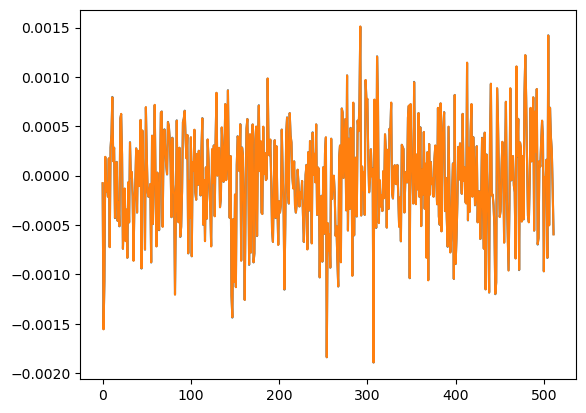

In [250]:
plt.plot(np.real(input_unquantized))
plt.plot(np.real(input_quantized))
plt.show()

In [251]:
coeffs_unquantized = np.linspace(500, 700, num=nfreqs)
coeffs_quantized = quantize(
    coeffs_unquantized, 16, 2, signed=False
)

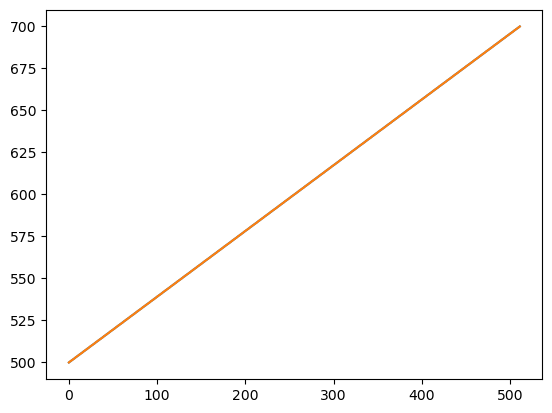

In [252]:
plt.plot(coeffs_unquantized)
plt.plot(coeffs_quantized)
plt.show()

In [253]:
equalized_voltage = input_quantized * coeffs_quantized
equalized_voltage_quantized = quantize(
    np.real(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True
) + 1j * quantize(np.imag(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True)

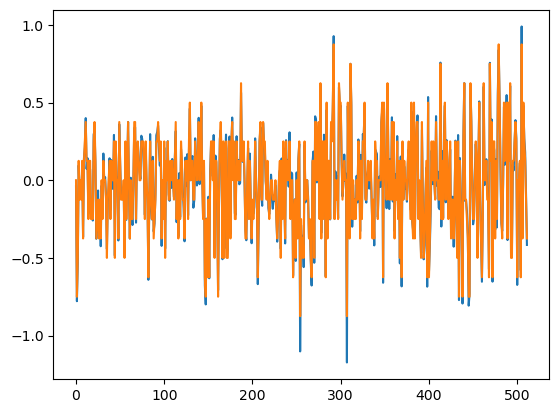

In [254]:
plt.plot(np.real(equalized_voltage))
plt.plot(np.real(equalized_voltage_quantized))
plt.show()

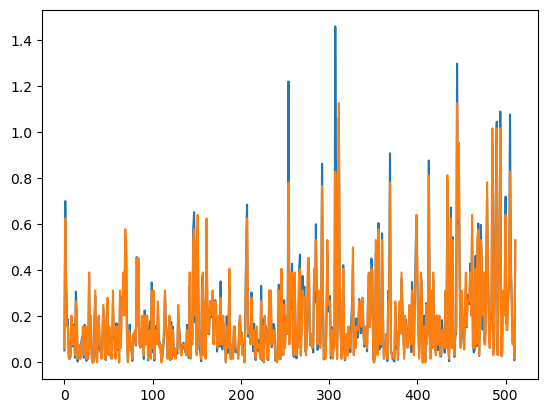

In [255]:
plt.plot(np.abs(equalized_voltage)**2)
plt.plot(np.abs(equalized_voltage_quantized)**2)
plt.show()

In [431]:
# Now accumulate

def get_equalized_spectra(noise_stddev=1e-3, equalization_coeffs=np.linspace(250, 350, num=nfreqs)):
    initial_resolution = 1 / 2**17
    final_resolution = 1 / 2**3
    # use_equalization_coeffs = (
    #    final_resolution / initial_resolution
    # ) / np.round(final_resolution / (equalization_coeffs * initial_resolution))
    use_equalization_coeffs = equalization_coeffs

    input_unquantized = np.random.normal(
        scale=noise_stddev, size=(nfreqs)
    ) + 1j * np.random.normal(scale=stddev, size=(nfreqs))

    input_quantized = quantize(
        np.real(input_unquantized), 18, 17, signed=True
    ) + 1j * quantize(np.imag(input_unquantized), 18, 17, signed=True)
    # coeffs_quantized = quantize(
    #    use_equalization_coeffs, 16, 2, signed=False
    # )
    coeffs_quantized = use_equalization_coeffs
    equalized_voltage = input_quantized * coeffs_quantized

    if False:  # dither
        equalized_voltage += quantize(
            np.random.normal(
                scale=0.0125, 
                size=[1]#np.shape(equalized_voltage)
            ),
            34,
            19,
            signed=True,
        ) + 1j * quantize(
            np.random.normal(
                scale=0.0125,
                size=[1]#np.shape(equalized_voltage)
            ),
            34,
            19,
            signed=True,
        )

    equalized_voltage_quantized = quantize(
       np.real(equalized_voltage),
       4,
       3,
       signed=True,
       enforce_symmetry=True,
    ) + 1j * quantize(
       np.imag(equalized_voltage),
       4,
       3,
       signed=True,
       enforce_symmetry=True,
    )
    return equalized_voltage_quantized, coeffs_quantized

ntrials = 1024**2
accumulated_autocorr = np.zeros((nfreqs), dtype=float)
for ind in range(ntrials):
    new_spectrum, coeffs_quantized = get_equalized_spectra(
        noise_stddev=1e-3 * 2**3,
        equalization_coeffs=np.linspace(275, 325, num=nfreqs) / 2**3,
    )
    accumulated_autocorr += np.abs(new_spectrum) ** 2
# Normalize
accumulated_autocorr /= ntrials

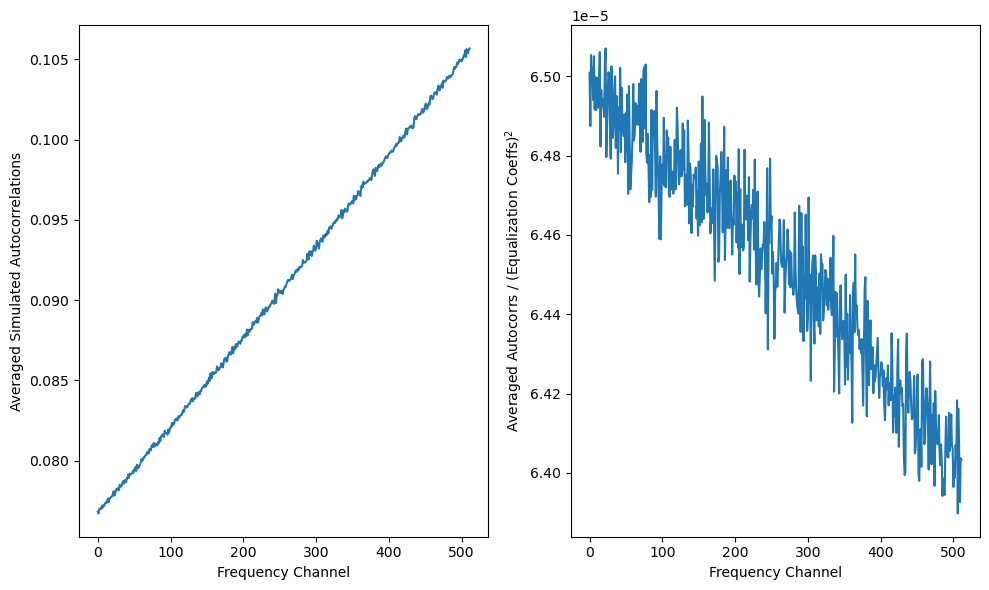

In [432]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
ax[0].plot(accumulated_autocorr)
ax[0].set_ylabel("Averaged Simulated Autocorrelations")
ax[0].set_xlabel("Frequency Channel")
ax[1].plot(accumulated_autocorr / coeffs_quantized**2)
ax[1].set_ylabel("Averaged Autocorrs / (Equalization Coeffs)$^2$")
ax[1].set_xlabel("Frequency Channel")
plt.tight_layout()
plt.show()

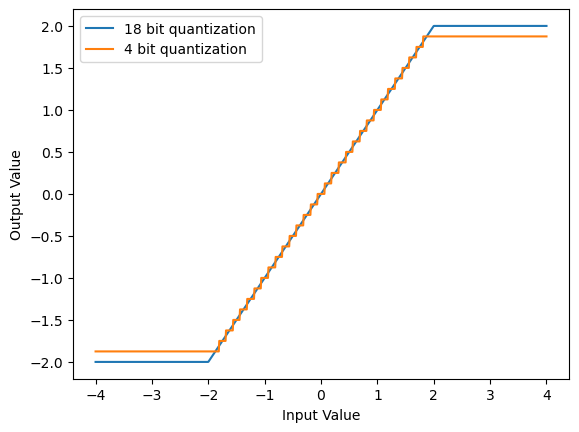

In [ ]:
input_values = np.linspace(-4, 4, 1000)
quantized_18_bit = quantize(input_values, 18, 17, signed=True)
quantized_4_bit = quantize(input_values, 4, 3, signed=True, enforce_symmetry=True)
plt.plot(input_values, quantized_18_bit, label="18 bit quantization")
plt.plot(input_values, quantized_4_bit, label="4 bit quantization")
plt.xlabel("Input Value")
plt.ylabel("Output Value")
plt.legend()
plt.show()

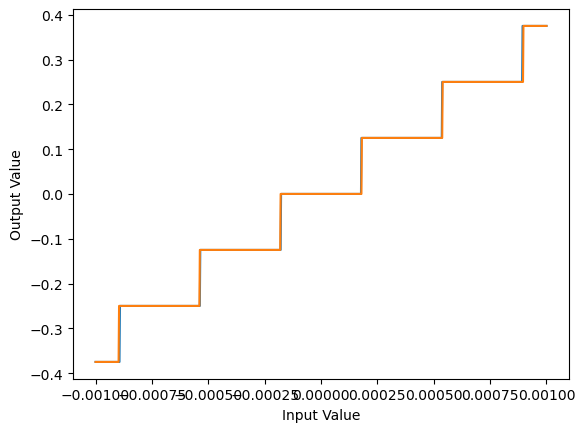

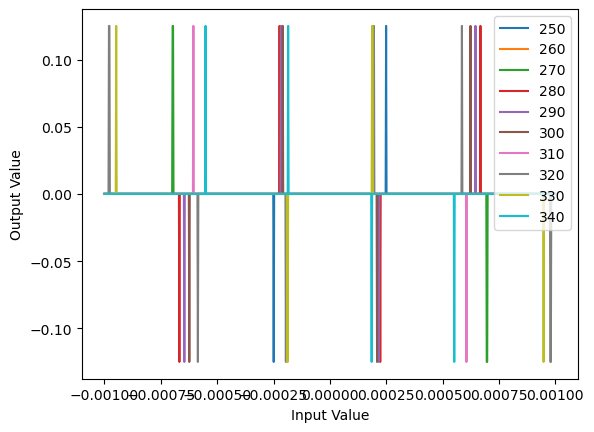

In [ ]:
input_values = np.linspace(-1e-3, 1e-3, 1000)
quantized_18_bit = quantize(input_values, 18, 17, signed=True)
# for equalization_coeff in np.arange(250, 350, 10):
for equalization_coeff in [350]:
    quantized_4_bit = quantize(
        input_values * equalization_coeff, 4, 3, signed=True, enforce_symmetry=True
    )
    requantized_4_bit = quantize(
        quantized_18_bit * equalization_coeff, 4, 3, signed=True, enforce_symmetry=True
    )
    plt.plot(input_values, quantized_4_bit, label=equalization_coeff)
    plt.plot(input_values, requantized_4_bit, label=equalization_coeff)
plt.xlabel("Input Value")
plt.ylabel("Output Value")
plt.show()

for equalization_coeff in np.arange(250, 350, 10):
    quantized_4_bit = quantize(
        input_values * equalization_coeff, 4, 3, signed=True, enforce_symmetry=True
    )
    requantized_4_bit = quantize(
        quantized_18_bit * equalization_coeff, 4, 3, signed=True, enforce_symmetry=True
    )
    plt.plot(input_values, requantized_4_bit-quantized_4_bit, label=equalization_coeff)
plt.xlabel("Input Value")
plt.ylabel("Output Value")
plt.legend()
plt.show()

In [283]:
initial_resolution = 1 / 2**17
initial_possible_values = np.arange(-1, 1, initial_resolution)
final_resolution = 1 / 2**3
final_possible_values = np.arange(-0.875, 0.875+final_resolution, final_resolution)

test_equalization_coeffs = np.arange(200, 400, 10.0)
# test_equalization_coeffs = (final_resolution / initial_resolution) / np.round(
#    final_resolution / (test_equalization_coeffs * initial_resolution)
# )
test_equalization_coeffs = quantize(test_equalization_coeffs, 16, 2, signed=False)
number_of_numbers_mapped = np.zeros(
    (len(test_equalization_coeffs), len(final_possible_values)), dtype=int
)
mean_value_mapped = np.zeros(
    (len(test_equalization_coeffs), len(final_possible_values)), dtype=float
)
for equalization_ind, equalization_coeff in enumerate(test_equalization_coeffs):
    equalized_possible_values = initial_possible_values * equalization_coeff
    for final_val_ind, final_val in enumerate(final_possible_values):
        number_of_numbers_mapped[equalization_ind, final_val_ind] = len(np.where(np.abs(equalized_possible_values-final_val) < final_resolution/2)[0])
        mean_value_mapped[equalization_ind, final_val_ind] = (
            np.sum(
                equalized_possible_values[
                    np.abs(equalized_possible_values - final_val) < final_resolution / 2
                ]
            )
            / number_of_numbers_mapped[equalization_ind, final_val_ind]
        )

In [284]:
print(final_resolution / initial_resolution)
print(2**14)

16384.0
16384


In [285]:
(final_resolution / initial_resolution) / np.round(
    final_resolution / (test_equalization_coeffs * initial_resolution)
)

array([199.80487805, 210.05128205, 221.40540541, 230.76056338,
       240.94117647, 248.24242424, 260.06349206, 268.59016393,
       277.69491525, 292.57142857, 297.89090909, 309.13207547,
       321.25490196, 327.68      , 341.33333333, 348.59574468,
       356.17391304, 372.36363636, 381.02325581, 390.0952381 ])

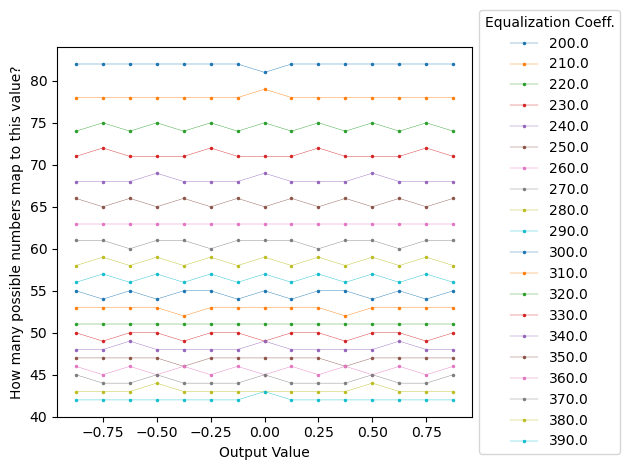

In [296]:
for equalization_ind, equalization_coeff in enumerate(test_equalization_coeffs):
    plt.plot(
        final_possible_values,
        number_of_numbers_mapped[equalization_ind, :],
        ".-", 
        label=equalization_coeff,
        linewidth=.3,
        markersize=3,
    )
plt.xlabel("Output Value")
plt.ylabel("How many possible numbers map to this value?")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Equalization Coeff.")
plt.tight_layout()
plt.show()

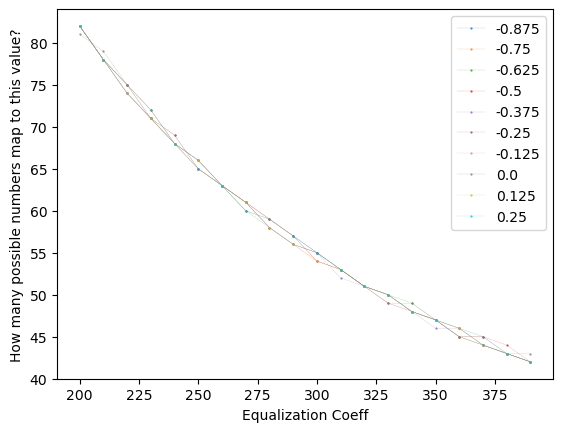

In [300]:
for output_ind, output_value in enumerate(final_possible_values[:10]):
    plt.plot(
        test_equalization_coeffs,
        number_of_numbers_mapped[:, output_ind],
        ".-",
        label=output_value,
        markersize=1,
        linewidth=0.1,
    )
plt.xlabel("Equalization Coeff")
plt.ylabel("How many possible numbers map to this value?")
plt.legend()
plt.show()

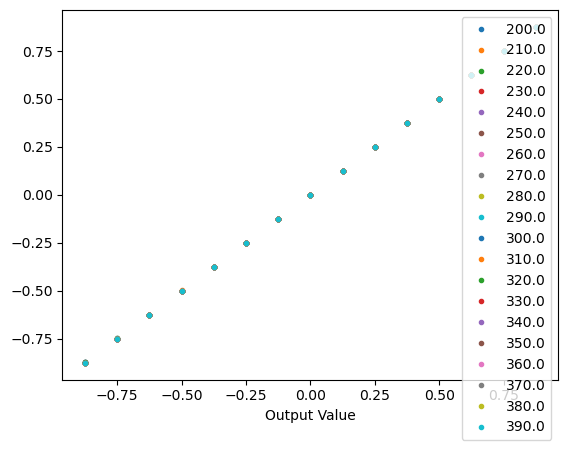

In [301]:
for equalization_ind, equalization_coeff in enumerate(test_equalization_coeffs):
    plt.plot(
        final_possible_values,
        mean_value_mapped[equalization_ind, :],
        ".",
        label=equalization_coeff,
    )
plt.xlabel("Output Value")
#plt.ylabel("How many possible numbers map to this value?")
plt.legend()
plt.show()

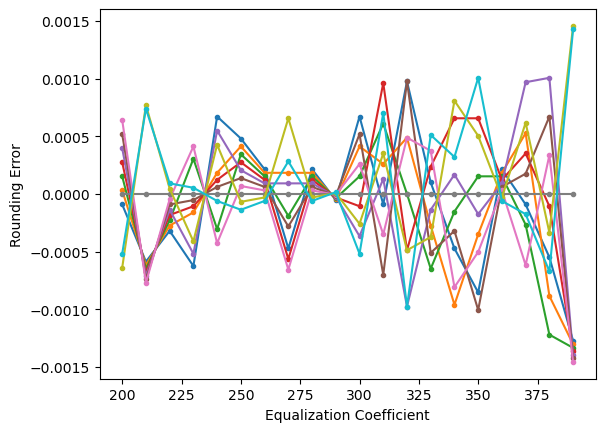

In [302]:
for final_val_ind, final_val in enumerate(final_possible_values[:10]):
    plt.plot(
        test_equalization_coeffs,
        mean_value_mapped[:, final_val_ind] - final_val,
        ".-",
    )
plt.xlabel("Equalization Coefficient")
plt.ylabel("Rounding Error")
plt.show()

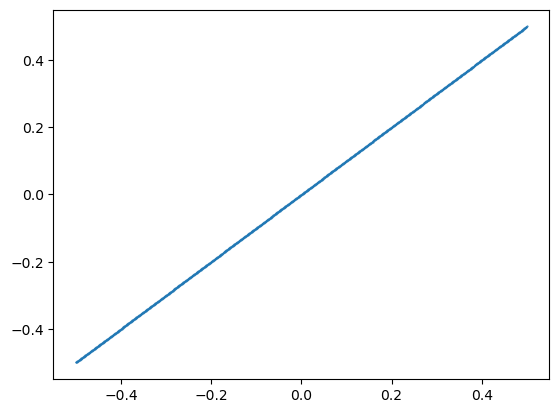

In [ ]:
test_input_values = np.linspace(-0.5,0.5,1000)
test_input_values_18_bit = quantize(
    test_input_values,
    18,
    17,
    signed=True,
    enforce_symmetry=False,
)
plt.plot(test_input_values, test_input_values_18_bit, ".", markersize=1)

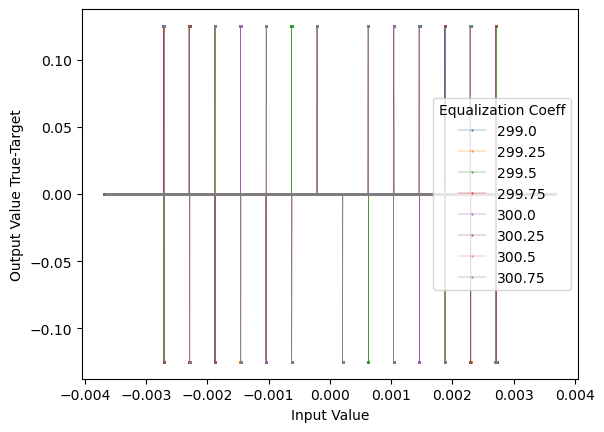

In [417]:
var_bias = []
for equalization_coeff in np.arange(299, 301, .25):
    # for equalization_coeff in [300.25]:
    test_input_values = np.arange(
        -1.1 / equalization_coeff,
        1.1 / equalization_coeff,
        1 / (equalization_coeff * 2**17),
    )
    test_input_values_18_bit = (
        quantize(
            test_input_values,
            18,
            17,
            signed=True,
            enforce_symmetry=False,
        )
        * equalization_coeff
    )
    output_values_target = quantize(
        test_input_values * equalization_coeff,
        4,
        3,
        signed=True,
        enforce_symmetry=True,
    )
    output_values = quantize(
        test_input_values_18_bit,
        4,
        3,
        signed=True,
        enforce_symmetry=True,
    )

    if False:
        plt.plot(
            test_input_values,
            test_input_values_18_bit,
            ".-",
            markersize=1,
            linewidth=0.3,
            label="18-bit quantized input, equalized",
        )
        plt.plot(
            test_input_values,
            output_values,
            ".-",
            markersize=3,
            linewidth=0.3,
            label="4-bit output, true",
        )
        plt.plot(
            test_input_values,
            output_values_target,
            ".-",
            markersize=1,
            linewidth=0.3,
            label="4-bit output, target",
        )
        plt.xlabel("Input Value")
        plt.ylabel("Output Value")
        plt.title(f"Equalization Coefficient: {equalization_coeff}")
        plt.legend()
        plt.show()

    plt.plot(
        test_input_values,
        output_values - output_values_target,
        ".-",
        markersize=1,
        linewidth=0.3,
        label=equalization_coeff,
    )
    plt.xlabel("Input Value")
    plt.ylabel("Output Value True-Target")
    plt.legend(title="Equalization Coeff")
    #plt.title(f"Equalization Coefficient: {equalization_coeff}")
plt.show()

    #var_bias.append(np.var(output_values) - np.var(output_values_target))

# plt.xlim([-2e-2, 2e-2])
# plt.ylim([-2e-2, 2e-2])

Text(0, 0.5, 'Variance Error')

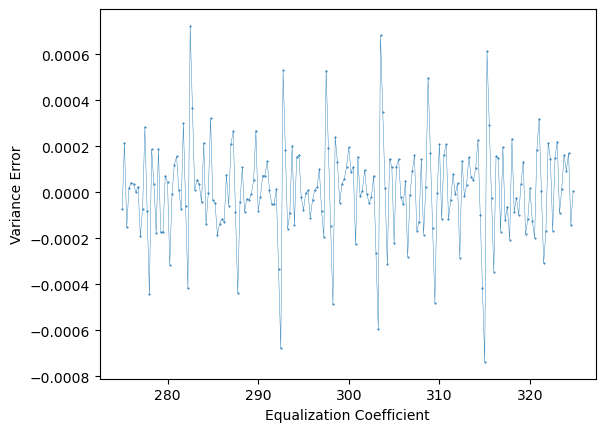

In [415]:
plt.plot(np.arange(275, 325, 0.25), var_bias, ".-", linewidth=0.3, markersize=1,)
plt.xlabel("Equalization Coefficient")
plt.ylabel("Variance Error")

In [340]:
1 / 2**3

0.125

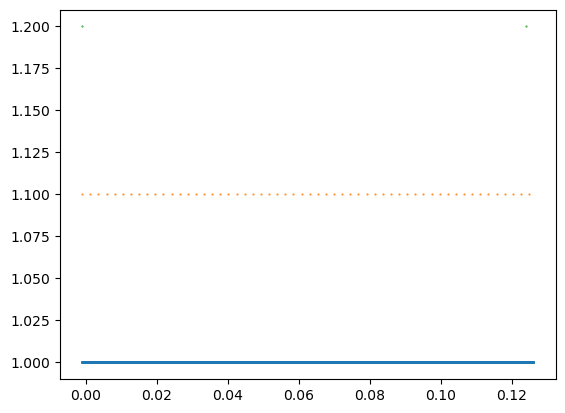

In [374]:
plot_range = [-0.001, 0.126]
orig_resolution = 1 / 2**17
end_resolution = 1 / 2**3

orig_resolution_plot_points = np.arange(
    np.min(plot_range), np.max(plot_range), orig_resolution
)
plt.plot(
    orig_resolution_plot_points,
    np.ones_like(orig_resolution_plot_points),
    ".",
    markersize=1,
)

equalized_resolution_plot_points = np.arange(
    np.min(plot_range), np.max(plot_range), orig_resolution * 300
)
plt.plot(
    equalized_resolution_plot_points,
    np.ones_like(equalized_resolution_plot_points) + .1,
    ".",
    markersize=1,
)

end_resolution_plot_points = np.arange(np.min(plot_range), np.max(plot_range), end_resolution)
plt.plot(
    end_resolution_plot_points,
    np.ones_like(end_resolution_plot_points) + .2,
    ".",
    markersize=1,
)

In [ ]:
np.arange(0, 1e-5, 1 / 2**17)

array([0.])

In [362]:
1 / 2**3

0.125

In [418]:
1.1/300

0.003666666666666667